# EDA 5: Pokročilejší manipulace a agregace


Další čtení pro dlouhé večery v tomto ročním období:
* https://github.com/alanderex/pydata-pandas-workshop/tree/master/notebooks
* https://github.com/TomAugspurger/pandas-head-to-tail/blob/master/notebooks/03-Iterators-Groupby.ipynb
* https://realpython.com/pandas-groupby/

In [1]:
import pandas as pd

## Analýza dat po skupinách

Jedním ze základních postupů v datové analýze je rozdělení dat do skupin, aplikace nějaké operace na jednotlivé skupiny a nakonec kombinace výsledků do vhodného datasetu. Anglicky se tento postup označuje jako *split-apply-combine*. Skupiny jsou často, byť ne nutně, definovány nějakou (kategorickou) proměnnou, např. by to mohla být barva, pohlaví nebo kontinent. Skupiny lze ale vytvářet i odvozováním, např. pomocí rozsahu nebo nebo vlastností časových řad. Oboje už jsme vlastně viděli v EDA 3, kdy jsme skupiny vytvářeli pro deštivé dny nebo jednotlivé roky.

Pojďme si to vysvětlit prakticky. Použijeme k tomu hezký dataset s výsledky voleb do českého horní komory parlamentu, do Senátu ČR. Data pochází z [webu ČSÚ](https://volby.cz/opendata/senat_vse/senat_vse_opendata.htm). Na tomto webu najdeme i [podrobnou dokumentaci](https://volby.cz/opendata/senat_vse/SENATregPopis.pdf).

In [2]:
import os
filename = "serk.csv"
if not os.path.exists(filename):
    filename = "https://raw.githubusercontent.com/PyDataCZ/pyladies-kurz/main/lessons/pydata/pandas_groupby/serk.csv"
df = pd.read_csv(filename, delimiter=";", encoding="windows-1250", parse_dates=["DATUMVOLEB"])

In [3]:
df.head(3).T

,0,1,2
DATUMVOLEB,1996-11-16 00:00:00,1996-11-16 00:00:00,1996-11-16 00:00:00
OBVOD,1,1,1
CKAND,1,2,3
VSTRANA,7,2,47
JMENO,Igor,Josef,Jan
PRIJMENI,Savič,Havlíček,Blažek
TITULPRED,Ing.,Mgr.,Ing.
TITULZA,NaN,NaN,CSc.
VEK,59.0,54.0,60.0
POVOLANI,primátor,advokát,projektant


### Krok 1: Split

Na rozdělení dat do skupin slouží metoda [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby). Nejjednodušší a možná i nejčastější použití je seskupení podle existujícího sloupce v tabulce. Třeba podle `OBVOD` nebo `DATUMVOLEB`.

In [4]:
districts = df.groupby("OBVOD")
districts

Dostali jsme objekt typu [`GroupBy`](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html). Pokud vám to připomíná `DatetimeIndexResampler` z [Explorativní analýzy a statistiky jedné proměnné](https://naucse.python.cz/2020/pydata-praha-jaro/pydata/eda-univariate-timeseries/), je to velice dobrá asociace. Tato operace totiž data jen rozdělila do skupin, ještě jsme ale neřekli, co s těmi skupinami chceme dělat.

### Krok 2 + 3: Apply + Combine

Na skupiny, které jsme vytvořili pomocí `groupby`, teď můžeme aplikovat nějakou operaci. To je právě krok *apply*. Nemá pro nás moc cenu oddělovat tento krok od třetího kroku *combine*, protože když už nějakou opraci aplikujeme, tak bychom rádi výsledek sestavili do výsledného datasetu. Pandas navíc tyto kroky sám nijak neodděluje.

*Pozn.: Apply a combine začne být více odděleno v nástrojích na zpracování velkých dat, které už se nevejdou pohodlně do operační paměti počítače a pandas na ně už nestačí. Apply pak probíhá po částech, třeba i distribuovaně na oddělených serverech, a výsledné combine se provádí sesbíráním částečných výsledků.* 

Použijeme teď jednoduchou agregační metodu `count`, která nám vrátí počet hodnot (po skupinách samozřejmě).

In [5]:
districts.count()

,DATUMVOLEB,CKAND,VSTRANA,JMENO,PRIJMENI,TITULPRED,TITULZA,VEK,POVOLANI,BYDLISTEN,...,PROC_K1,URIZ_PR_K1,ZVOLEN_K1,LOS_K1,HLASY_K2,PROC_K2,URIZ_PR_K2,ZVOLEN_K2,LOS_K2,NAZEV_VS
OBVOD,,,,,,,,,,,,,,,,,,,,,
1,52,52,52,51,51,33,3,51,51,51,...,52,52,52,52,52,52,52,52,52,39
2,40,40,40,40,40,24,1,40,40,40,...,40,40,40,40,40,40,40,40,40,31
3,39,39,39,39,39,27,1,39,39,39,...,39,39,39,39,39,39,39,39,39,32
4,49,49,49,48,48,34,1,48,48,48,...,49,49,49,49,49,49,49,49,49,38
5,53,53,53,53,53,36,1,53,53,53,...,53,53,53,53,53,53,53,53,53,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,32,32,32,32,14,2,32,32,32,...,32,32,32,32,32,32,32,32,32,26
78,52,52,52,52,52,38,7,52,52,52,...,52,52,52,52,52,52,52,52,52,44
79,43,43,43,42,42,29,3,42,42,42,...,43,43,43,43,43,43,43,43,43,31


Na levé straně v indexu vidíme skupiny, podle kterých se dataset agregoval a do sloupců se daly všechny sloupce, na které bylo možné aplikovat naši agregační funkci (v tom případě na všechny zbylé).

Z čísel si můžeš všimnout, že u některých chybí údaje o titulech.

Než aplikujeme krok *apply*, můžeme si vybrat, na který ze sloupců tak učiníme, trochu si tím zpřehledníme výstup. Pokud si vybereme jen jeden sloupec, dostaneme Series.

In [6]:
districts["JMENO"].count()

OBVOD
1     51
2     40
3     39
4     48
5     53
      ..
77    32
78    52
79    42
80    42
81    41
Name: JMENO, Length: 81, dtype: int64

Tento krok si můžeme trochu zjednodušit - než abychom se doptávali na `count` nad jedním sloupcem v rámci agregace, můžeme se doptat na *velikost* každé ze skupin.

In [7]:
districts.size()

OBVOD
1     52
2     40
3     39
4     49
5     53
      ..
77    32
78    52
79    43
80    42
81    41
Length: 81, dtype: int64

In [8]:
df.head(3)

,DATUMVOLEB,OBVOD,CKAND,VSTRANA,JMENO,PRIJMENI,TITULPRED,TITULZA,VEK,POVOLANI,...,PROC_K1,URIZ_PR_K1,ZVOLEN_K1,LOS_K1,HLASY_K2,PROC_K2,URIZ_PR_K2,ZVOLEN_K2,LOS_K2,NAZEV_VS
0,1996-11-16,1,1,7,Igor,Savič,Ing.,NaN,59.0,primátor,...,17.01,17.006020,2,0,9301,38.69,38.686465,0,0,NaN
1,1996-11-16,1,2,2,Josef,Havlíček,Mgr.,NaN,54.0,advokát,...,1.93,1.928755,0,0,0,0.00,0.000000,0,0,NaN
2,1996-11-16,1,3,47,Jan,Blažek,Ing.,CSc.,60.0,projektant,...,12.50,12.500479,0,0,0,0.00,0.000000,0,0,NaN


**Úkol:** Rozděl data podle data voleb (`DATUMVOLEB`) a vypiš počet záznamů v každé skupině. Dokážeš výsledek setřídit podle velikosti skupin? 

Možná sis všimla, jaký je u výsledku index. Pokud ne, nevadí, určitě si všimneš teď. Zkusíme totiž vytvořit skupiny ne z jednoho sloupce, ale ze dvou. Pojďme si rozdělit volby podle data a obvodu.

In [9]:
date_district_counts = df.groupby(["DATUMVOLEB", "OBVOD"]).count()
date_district_counts

CKAND  VSTRANA  JMENO  PRIJMENI  TITULPRED  TITULZA  VEK  \
DATUMVOLEB OBVOD                                                             
1996-11-16 1          8        8      8         8          5        1    8   
           2          9        9      9         9          4        0    9   
           3          7        7      7         7          3        0    7   
           4          6        6      6         6          4        0    6   
           5          8        8      8         8          5        0    8   
...                 ...      ...    ...       ...        ...      ...  ...   
2022-09-23 67         7        7      7         7          4        3    7   
           70         8        8      8         8          8        1    8   
           73         7        7      7         7          3        1    6   
           76         6        6      6         6          6        1    6   
           79         7        7      7         7          7        2    7   

                  POVOLANI  BYDLISTEN  BYDLISTEK  ...  PROC_K1  URIZ_PR_K1  \
DATUMVOLEB OBVOD                                  ...                        
1996-11-16 1             8          8          8  ...        8           8   
           2             9          9          9  ...        9           9   
           3             7          7          7  ...        7           7   
           4             6          6          6  ...        6           6   
           5             8          8          8  ...        8           8   
...                    ...        ...        ...  ...      ...         ...   
2022-09-23 67            7          7          7  ...        7           7   
           70            8          8          8  ...        8           8   
           73            7          7          7  ...        7           7   
           76            6          6          6  ...        6           6   
           79            7          7          7  ...        7           7   

                  ZVOLEN_K1  LOS_K1  HLASY_K2  PROC_K2  URIZ_PR_K2  ZVOLEN_K2  \
DATUMVOLEB OBVOD                                                                
1996-11-16 1              8       8         8        8           8          8   
           2              9       9         9        9           9          9   
           3              7       7         7        7           7          7   
           4              6       6         6        6           6          6   
           5              8       8         8        8           8          8   
...                     ...     ...       ...      ...         ...        ...   
2022-09-23 67             7       7         7        7           7          7   
           70             8       8         8        8           8          8   
           73             7       7         7        7           7          7   
           76             6       6         6        6           6          6   
           79             7       7         7        7           7          7   

                  LOS_K2  NAZEV_VS  
DATUMVOLEB OBVOD                    
1996-11-16 1           8         0  
           2           9         0  
           3           7         0  
           4           6         0  
           5           8         0  
...                  ...       ...  
2022-09-23 67          7         7  
           70          8         8  
           73          7         7  
           76          6         6  
           79          7         7  

[447 rows x 24 columns]

Máme tedy skupiny, které jsou definované dvojicí hodnot datum a obvod (`DATUMVOLEB`, `OBVOD`). A to je přesně důvod, proč existuje v Pandas [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html).

## Co je ten `DataFrameGroupBy object`?

Na začátku jsme si udělali základní agregaci bez aplikace funkcí a dostali jsme jakýsi objekt. Je možné s ním něco dělat, aniž bychom agregovali? Ukazuje se, že ano.

Než se k tomu dostaneme, zkusme jeden **úkol**: Rozděl náš dataframe podle stran - tzn. pro každou stranu vytvoř dataframe a ten ulož do zvláštního souboru. Např. `Democrat` půjde do Democrat.csv atd.

In [10]:
df.groupby('DATUMVOLEB')

Jedna klíčová funkce, kterou nám tento objekt nabízí, je iterace.

In [11]:
groups = df.groupby('DATUMVOLEB')

next(iter(groups)) # timhle ziskame prvni element pri iteraci (for cyklu)

(Timestamp('1996-11-16 00:00:00'),
     DATUMVOLEB  OBVOD  CKAND  VSTRANA     JMENO  PRIJMENI   TITULPRED TITULZA  \
 0   1996-11-16      1      1        7      Igor     Savič        Ing.     NaN   
 1   1996-11-16      1      2        2     Josef  Havlíček        Mgr.     NaN   
 2   1996-11-16      1      3       47       Jan    Blažek        Ing.    CSc.   
 3   1996-11-16      1      4       53  Vladimír  Kulhánek         NaN     NaN   
 4   1996-11-16      1      5       37     Karel     Masný       MUDr.     NaN   
 ..         ...    ...    ...      ...       ...       ...         ...     ...   
 583 1996-11-16     81      6       53  Jaroslav  Zapletal       PhDr.     NaN   
 584 1996-11-16     81      7       81  Jaroslav     Mlčák       MUDr.     NaN   
 585 1996-11-16     81      8        7     Josef    Vacula        Ing.     NaN   
 586 1996-11-16     81      9       80   Vojtěch     Ondra        Mgr.     NaN   
 587 1996-11-16     81     10      345       Jan     Jegla  JUD

K čemu nám to může být? Při agregaci se data drasticky zjednodušují a nemusíme si vždy být jisti, že naše agregace jsou napsané správně. Pomocí iterace nad skupinami si můžeme zobrazit všechna data před agregací.

In [12]:
for date, sdf in df.groupby('DATUMVOLEB'):
    sdf.to_csv(str(date) + '.csv')

Tuto funkcionalitu asi tolik neoceníte, když jde jen o jeden sloupec, zde `DATUMVOLEB`, tedy alternativa není tak složitá. Ale jakmile začnete agregovat nad více sloupci, začne být iterace čím dál užitečnější.

## Další agregační funkce

Dosud jsme agregovali jen pomocí `.size` nebo `.count`, ale existuje spousta další agregačních metod, zejm. těch numerických.

Pro snadnější práci s agregacemi budeme používat metodu `.agg`, která akceptuje slovník. Tento slovník udává, *co* chceme agregovat (klíč) a *jak* to chceme agregovat (hodnota). S tím, že způsobů agregace pro jeden sloupec může být více naráz. Ukážeme si.

In [13]:
df.groupby('DATUMVOLEB').agg({'VEK': 'max'}).head()

,VEK
DATUMVOLEB,
1996-11-16,91.0
1998-11-14,73.0
1999-08-28,74.0
2000-11-12,70.0
2002-10-25,87.0


In [14]:
df.groupby('DATUMVOLEB').agg({
    'VEK': ['min', 'max'],
    'VSTRANA': 'nunique'}
).head()

VEK       VSTRANA
             min   max nunique
DATUMVOLEB                    
1996-11-16  40.0  91.0      33
1998-11-14  40.0  73.0      18
1999-08-28  45.0  74.0       8
2000-11-12  40.0  70.0      20
2002-10-25  40.0  87.0      33

## Transformace sloupců

Většinu času jsme pracovali s daty, které jsme načetli ze souboru a krom nějakého základního čištění jsme je žádným způsobem neměnili. Teď si ukážeme, jak udělat některé základní transformace.

Může nás například zajímat, které hodnoty máme či nemáme v daném sloupci. K získání takové informace sloužít metody `.isnull` a `.notnull`, které jsou navzájem inverzní.

In [15]:
df['POVOLANI'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
3449    False
3450    False
3451    False
3452    False
3453    False
Name: POVOLANI, Length: 3454, dtype: bool

Series má metodu `isnull`, která nám vrátí True/False hodnoty podle toho, jestli daná hodnota chybí nebo ne (NULL v SQL). Pro snadnější pochopení je možné použít inverzní metodu `notnull`.

Může náš též zajímat, zda řádky nabývají některou z vybraných hodnot.

In [16]:
df['JMENO'].isin(['Jan', 'Jana'])

0       False
1       False
2        True
3       False
4       False
        ...  
3449    False
3450    False
3451    False
3452    False
3453    False
Name: JMENO, Length: 3454, dtype: bool

... nebo jak se hodnoty liší mezi řádky (dává smysl jen pro číselná data nebo pro sloupce obsahující datum)

In [17]:
df['VEK'].diff()

0        NaN
1       -5.0
2        6.0
3       -3.0
4       -3.0
        ... 
3449     7.0
3450   -14.0
3451    16.0
3452     3.0
3453   -22.0
Name: VEK, Length: 3454, dtype: float64

### .str a .dt metody

Můžeme též testovat různé vlastnosti stringů a dat (od slova datum). Slouží k tomu [.str](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) a [.dt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).

In [18]:
df['PRIJMENI'].str.len()

0        5.0
1        8.0
2        6.0
3        8.0
4        5.0
        ... 
3449    10.0
3450     7.0
3451     7.0
3452     8.0
3453     8.0
Name: PRIJMENI, Length: 3454, dtype: float64

Často používanými metodami v rámci `.str` je `contains` nebo `.lower/upper`

In [19]:
names = pd.Series(['JOHN', 'Jean-Luc', 'Mary-Jane', 'Kate', 'John'])
names.str.contains('-')

0    False
1     True
2     True
3    False
4    False
dtype: bool

In [20]:
names[names.str.contains('-')]

1     Jean-Luc
2    Mary-Jane
dtype: object

Zatímco `.str.contains` použijeme zpravidla na filtrování, `.lower` poslouží třeba na unifikaci dat, která se pak lépe agregují (a deduplikují).

In [21]:
names.value_counts()

JOHN         1
Jean-Luc     1
Mary-Jane    1
Kate         1
John         1
Name: count, dtype: int64

In [22]:
names.str.lower().value_counts()

john         2
jean-luc     1
mary-jane    1
kate         1
Name: count, dtype: int64

Z `.dt` si ukážeme jak vytáhnout z data rok.

In [23]:
election_years = df['DATUMVOLEB'].dt.year

election_years#.value_counts()

0       1996
1       1996
2       1996
3       1996
4       1996
        ... 
3449    2022
3450    2022
3451    2022
3452    2022
3453    2022
Name: DATUMVOLEB, Length: 3454, dtype: int32

**Úkol:** vyfiltruj kandidáty, kterým v době kandidatury bylo 40 let

## Agregace nad nesloupci

Dosud jsme vždy agregovali nad něčím, co jsme měli v DataFramu. Je ale možné agregovat nad daty, které tam vůbec nemáme, alespoň ne explicitně. K tomu budou sloužit transformace, které jsme si právě ukázali.

Kromě názvu sloupce můžeme do `groupby` vložit nějakou Series (!), která má stejný tvar jako naše sloupce a pandas podle toho bude umět agregovat. Jaká taková Series se nabízí? Nejlépe transformace nějakého existujícího sloupce.

Můžeme tak agregovat data na základě _měsíce_, kdy se dané volby konaly. A to aniž bychom tento sloupec přidávali do dataframu. Tato metoda nám tak pomůže dělat kreativní agregace bez nutnosti měnit naše data.

In [24]:
df.groupby([
    df['DATUMVOLEB'].dt.month,
]).size()

DATUMVOLEB
1       28
3       10
4       27
5        9
6       11
8        8
9      191
10    2053
11    1117
dtype: int64

Můžeme samozřejmě přidávat další a další (ne)sloupce.

In [25]:
df.groupby([
    df['OBVOD'],
    df['DATUMVOLEB'].dt.month,
]).size()

OBVOD  DATUMVOLEB
1      9             11
       10            18
       11            23
2      10            26
       11            14
                     ..
80     1             10
       10            22
       11            10
81     10            31
       11            10
Length: 199, dtype: int64

Měsíce jsou fajn, je jich jen 12, ale co když budeme chtít agregovat nad roky voleb?

In [26]:
df.groupby([
    df['OBVOD'],
    df['DATUMVOLEB'].dt.year,
]).size().count()

447

Dostáváme poněkud velký dataset, který nám toho moc neřekne. S tím nám pomůže další kapitola.

### Binning

Sice máme věky lidí, ale přeci jen jich je spousta a moc nám to neřekne, určitě se podle nich nedá dobře agregovat.

<Axes: >

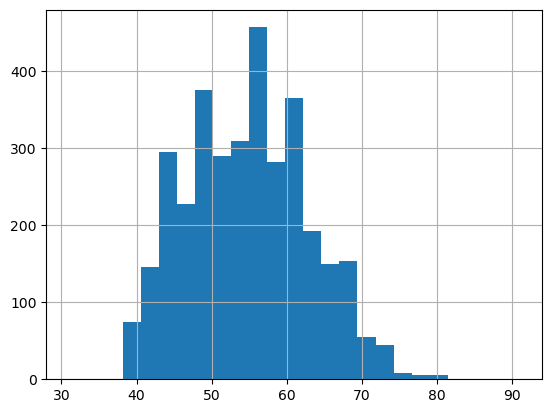

In [27]:
df['VEK'].hist(bins=25)

In [28]:
df['VEK'].value_counts().head()

VEK
56.0    163
54.0    161
55.0    159
52.0    159
53.0    149
Name: count, dtype: int64

Ani histogram, ani `value_counts` nám žádné moc hodnotné informace nepřinesl. Budeme muset data trochu seskupit. Na to v pandas existuje několik možností.

První z nich je nám již známý `.value_counts`, kterému můžeme přihodit argument `bins`, který znamená, že nechceme frekvence jednotlivých hodnot, ale že chceme seskupit data do několika intervalů.

Podívejme 

In [29]:
df['VEK'].value_counts(bins=10)

(49.0, 55.0]      899
(55.0, 61.0]      836
(43.0, 49.0]      679
(61.0, 67.0]      512
(37.0, 43.0]      299
(67.0, 73.0]      176
(73.0, 79.0]       34
(79.0, 85.0]        2
(85.0, 91.0]        2
(30.939, 37.0]      1
Name: count, dtype: int64

Co když nám takové samorozdělení nestačí? Na to je `pandas.cut`, resp. `pd.cut`. Má spoustu možností, doporučujeme [projít dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

In [30]:
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]
pd.cut(df['VEK'], bins)

0       (50, 60]
1       (50, 60]
2       (50, 60]
3       (50, 60]
4       (50, 60]
          ...   
3449    (50, 60]
3450    (40, 50]
3451    (50, 60]
3452    (60, 70]
3453    (40, 50]
Name: VEK, Length: 3454, dtype: category
Categories (8, interval[int64, right]): [(20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80] < (80, 90] < (90, 100]]

In [31]:
pd.cut(df['VEK'], bins).value_counts()

VEK
(50, 60]     1476
(40, 50]     1044
(60, 70]      752
(70, 80]       89
(30, 40]       75
(80, 90]        3
(90, 100]       1
(20, 30]        0
Name: count, dtype: int64

Nevýhodou `pd.cut` je, že intervaly jsou určeny uživatelem a může chvíli trvat, než je člověk odladí. Více automatická je možnost určit intervaly pomocí statistického rozložení dat, k tomu slouží `pd.qcut`, ten místo hranic intervalů bere kvantily.

In [32]:
pd.qcut(df['VEK'], [0, .1, .5, .9, 1]).value_counts()

VEK
(44.0, 55.0]      1478
(55.0, 66.0]      1287
(30.999, 44.0]     400
(66.0, 91.0]       275
Name: count, dtype: int64

_Samozřejmostí tohoto seskupování je, že tyto transformované sloupce opět můžeme použít pro agregaci._

**Úkol**: Jak se postupem času měnil počet kandidujících lidí důchodového věku (65 let a více)? Spočítej počet lidí pod 65, nad 65 a nad 90 v každém roce, kdy se konaly volby do senátu.

### Kontingenční tabulky

Pokud budeme agregovat nad několika sloupci, může se nám stát, že z DataFramu se nám stane jedna dlouhá nudle. V tom se nedá moc dobře vyznat. Pokud jste s takovými daty někdy pracovali v Excelu, možná vám bude povědomá funkce kontigenčních tabulek, v angličtině _pivot tables_.

Než začneme pivotovat, vytvořme si malý dataset - bude to jednoduchá agregace na základě roku voleb a obvodu, ve kterém se kandidovalo.

In [33]:
summary = df.assign(ROK=df["DATUMVOLEB"].dt.year)
summary = summary.groupby(['ROK', 'OBVOD'], as_index=False).size()
summary = summary.rename(columns={'size': 'count'})
summary

,ROK,OBVOD,count
0,1996,1,8
1,1996,2,9
2,1996,3,7
3,1996,4,6
4,1996,5,8
...,...,...,...
442,2022,67,7
443,2022,70,8
444,2022,73,7
445,2022,76,6


Součástí každého `pivot`u jsou tři faktory - specifikace,

1. který se sloupců chceme v indexu
2. který bude ve sloupcích
3. který sloupec se přiřadí do hodnot v DataFramu

Hezky je to vidět [na tomto diagramu](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html).

In [34]:
summary.pivot(index='OBVOD', columns='ROK', values='count').fillna("")

ROK,1996,1998,1999,2000,2002,2003,2004,2006,2007,2008,2010,2011,2012,2014,2016,2017,2018,2019,2020,2022
OBVOD,,,,,,,,,,,,,,,,,,,,
1,8.0,5.0,,,,,10.0,,,,10.0,,,,8.0,,,,,11.0
2,9.0,,,5.0,,,,8.0,,,,,9.0,,,,9.0,,,
3,7.0,,,,8.0,,,,,7.0,,,,8.0,,,,,9.0,
4,6.0,5.0,,,,,9.0,,,,8.0,,,,7.0,9.0,,,,5.0
5,8.0,,,5.0,,,,10.0,9.0,,,,12.0,,,,9.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,6.0,,,7.0,,,,5.0,,,,,8.0,,,,6.0,,,
78,8.0,,,,9.0,,,,,7.0,,,,12.0,,,9.0,,7.0,
79,8.0,4.0,,,,,9.0,,,,8.0,,,,7.0,,,,,7.0


Omezením metody `pivot` je to, že umí jen otáčet DataFrame, ale pokud některému z políček odpovídá více hodnot, vyhodí vám chybu, protože neví, jak je má agregovat. Pivot je opravdu jen pro otáčení.

Na komplexnější agregace tu je podobně pojmenovaný `pivot_table`.

In [35]:
summary = df.assign(ROK=df["DATUMVOLEB"].dt.year)
summary = summary.groupby(['OBVOD', 'ROK', 'TITULPRED'], as_index=False).size()
summary = summary.rename(columns={'size': 'count'})
summary

,OBVOD,ROK,TITULPRED,count
0,1,1996,Ing.,2
1,1,1996,MUDr.,1
2,1,1996,Mgr.,2
3,1,1998,Ing.,1
4,1,1998,MUDr.,1
...,...,...,...,...
1707,81,2014,Ing.,4
1708,81,2014,doc. PhDr.,1
1709,81,2014,doc. RNDr.,1
1710,81,2020,Ing.,1


`pivot_table` nabízí možnost přiřadit do některé z dimenzí (do indexu či sloupců) vícero sloupců, a následně pak vytvoří víceúrovňový index. Jde též specifikovat, jaká funkce se aplikuje, pokud na buňku připadá více hodnot (jako v Excelu).

Více detailů najdete [v dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

In [36]:
wide = summary.pivot_table(index=['OBVOD', 'TITULPRED'], columns=['ROK'], values='count', fill_value='')

wide.head(10)

ROK             1996 1998 1999 2000 2002 2003 2004 2006 2007 2008 2010 2011  \
OBVOD TITULPRED                                                               
1     Bc.                                                                     
      Ing.       2.0  1.0                      2.0                 1.0        
      JUDr.                                    1.0                 2.0        
      MUDr.      1.0  1.0                      1.0                 3.0        
      Mgr.       2.0  3.0                      1.0                 1.0        
      Mgr. Bc.                                                                
2     Bc.                                                                     
      Ing.       1.0            1.0                 1.0                       
      JUDr.      1.0                                                          
      MUDr.                     1.0                 1.0                       

ROK             2012 2014 2016 2017 2018 2019 2020 2022  
OBVOD TITULPRED                                          
1     Bc.                  1.0                           
      Ing.                 2.0                      5.0  
      JUDr.                                              
      MUDr.                1.0                      1.0  
      Mgr.                                               
      Mgr. Bc.                                      1.0  
2     Bc.                            1.0                 
      Ing.       6.0                 2.0                 
      JUDr.                                              
      MUDr.

Kdyby ti přišlo matoucí, že tu jsou dvě podobné funkce na kontigenční tabulky, tak tě ještě víc zmateme, protože existuje ještě `pd.crosstab`. Do detailů zde už zacházet nebudeme, doporučujeme [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html).

### Inverzní kontigenční tabulky

Zatímco na kontigenční tabulky mnozí narazili, jejich inverzní funkcionalita je celkem neznámá, a zajímavá. Funguje přesně tak, jak píšeme - vezme se široká tabulka, ve které je jedna z dimenzí ve sloupcích, a zúží a prodlouží se tím, že se ony názvy sloupcí překonvertují do samotného sloupce. Příklad bude názornější.

V pandas se na tuto inverzní operaci používá metoda `melt`. Její delší výčet argumentů je tradičně [v dokumentaci](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html).

Mějme dataset, kde je výkon v různých regionech fiktivní země. Nevýhodou je, že nemůžeme úplně dívat na časové řady, protože roky, ke kterým údaje platí, jsou ve sloupcích, ne v řádcích. Takto široké tabulky jsou celkem populární třeba u dat o počasí.

In [37]:
df = pd.DataFrame({
    'region': ['North', 'South', 'East', 'West'],
    '2000': [200, 100, 50, 1000],
    '2005': [450, 10, 510, 1040],
    '2010': [10, 500, 950, 500],
    '2015': [550, 20, 50, 10],
    '2020': [1, 1, 5, 10],
})
df

,region,2000,2005,2010,2015,2020
0,North,200,450,10,550,1
1,South,100,10,500,20,1
2,East,50,510,950,50,5
3,West,1000,1040,500,10,10


`pd.melt` zajímá, který ze sloupců nějak identifikuje dané řádky (`id_vars`) a které sloupce obsahují hodnoty (`value_vars`). Zbylé dva argumenty slouží jen k přejmenování sloupců (`var_name`, `value_name`).

In [38]:
long = df.melt(id_vars=['region'], value_vars=['2000', '2005', '2010', '2015', '2020'],
        var_name='year', value_name='output')

long

,region,year,output
0,North,2000,200
1,South,2000,100
2,East,2000,50
3,West,2000,1000
4,North,2005,450
5,South,2005,10
6,East,2005,510
7,West,2005,1040
8,North,2010,10
9,South,2010,500


**Úkol:** vem tento dlouhý dataset a udělej z něj ten původní, široký. (Neřeš, pokud máš někde index, kde před tím nebyl.)